<div style="display: flex; text-align:center; background-color: RGB(58,69,203);border: 1px solid RGB(51,165,182);" >
<h1 style="margin: auto;color:RGB(255,255,255); padding: 30px;margin-left: 2em; text-indent: -2em">PROJET 10 - Détectez des faux billets avec R ou Python - MODELISATION - PRODUCTION
    
</h1>
</div>

<div style="border-style: double;border-width: 5px;border-color: RGB(58,69,203);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182);margin-left: 4.5em; text-indent: -4.5em"><a id="00">SOMMAIRE</a> </h3>

  - 1. **[MODELISATION](#1)**
     - 1. [Regression logistique](#11)
     - 2. [K-Means](#12)
        - 1. [ACP](#121)
        - 2. [K-means](#122) 
   
  - 2. **[PRODUCTION](#2)**
     - 1. [Test de l'algorithme](#21)
    
</div>


<div style="border: 1px solid RGB(58,69,203);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em">0.0 - Importation des librairies et declaration de fonctions</h3>
</div>

In [1]:
#pip install missingno

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
from scipy.stats import t, shapiro
pd.set_option('display.max_row',100)

#
import statsmodels
import statsmodels.api as sm

#sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples ,adjusted_rand_score
from sklearn.decomposition import PCA








In [3]:
# fonction Matrice de confusion 
def confusion(y_test,y_test_pred):
    
    mat =confusion_matrix(y_test,y_test_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

<div style="background-color: RGB(58,69,203);" >
<h2 style="margin: auto;color:RGB(255,255,255) ;padding: 20px;margin-left: 4.5em; text-indent: -4.5em">1 - MODELISATION avec statmodel
</h2>
</div>

In [4]:
billets = pd.read_csv("./data/cleaned/billets_clean.csv",sep=',')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_encode
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


In [5]:
billets.isnull().sum()

is_genuine           0
diagonal             0
height_left          0
height_right         0
margin_low           0
margin_up            0
length               0
is_genuine_encode    0
dtype: int64

<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="11">1 - 1. Regression logistique </a></h3>
</div>

In [6]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length', 'is_genuine_encode'],
      dtype='object')

In [7]:

# Sélectionner les variables explicatives et la variable d'intérêt
X = billets[[ 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]
y = billets['is_genuine_encode']

In [8]:
# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(y_train, X_train)

In [10]:
# Ajuster le modèle aux données d'apprentissage
result = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.030574
         Iterations 11


In [11]:
# Afficher le résumé des résultats de la régression
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:      is_genuine_encode   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Aug 2024   Pseudo R-squ.:                  0.9515
Time:                        01:51:21   Log-Likelihood:                -36.689
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                2.934e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal        -0.6764      0.777     -0.870      0.384      -2.200       0.847
height_left     -2.0221      1.186     -1.706      0.088      -4.346       0.302
height_right    -2.3795      1.007     -2.36

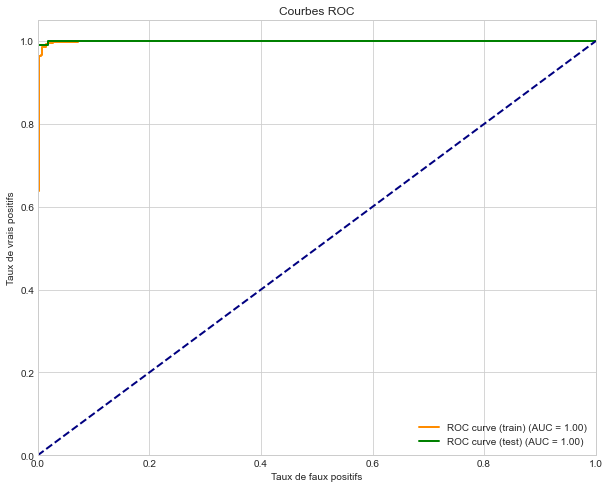

In [12]:
from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = result.predict(X_train)
y_test_pred = result.predict(X_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()
fig.savefig('./graphiques/regression_logistique/courbe_ROC.png', dpi=fig.dpi*10)
plt.close(fig)

In [13]:
from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
y_pred = result.predict(X_test) > 0.5

# Générer le rapport de classification
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification

print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       110
           1       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [14]:
confusion_matrix_test = confusion_matrix(y_test,y_pred)
confusion_matrix_test = pd.DataFrame(confusion_matrix_test)
confusion_matrix_test.columns = [f"pred_{i}" for i in confusion_matrix_test.columns]
confusion_matrix_test.index = [f"test_{i}" for i in confusion_matrix_test.index]
confusion_matrix_test

,pred_0,pred_1
test_0,108,2
test_1,1,189


In [15]:
from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
y_pred = result.predict(X_train) > 0.5

# Générer le rapport de classification
report = classification_report(y_train, y_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       390
           1       0.99      1.00      0.99       810

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [16]:

confusion_matrix_train = confusion_matrix(y_train,y_pred)
confusion_matrix_train = pd.DataFrame(confusion_matrix_train)
confusion_matrix_train.columns = [f"pred_{i}" for i in confusion_matrix_train.columns]
confusion_matrix_train.index = [f"test_{i}" for i in confusion_matrix_train.index]
confusion_matrix_train

,pred_0,pred_1
test_0,383,7
test_1,3,807


<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="32">1 - 2. K-MEANS</a></h3>
</div>

### ACP

In [17]:
# Normaliser les données
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

In [18]:
pca.explained_variance_

array([2.59887685, 1.01805796, 0.78209394, 0.70999467, 0.57641717,
       0.31856208])

In [19]:
# Analyse des valeurs propres
comp = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
comp

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,2.598877,43.0,43.0
1,Dim2,1.018058,17.0,60.0
2,Dim3,0.782094,13.0,73.0
3,Dim4,0.709995,12.0,85.0
4,Dim5,0.576417,10.0,95.0
5,Dim6,0.318562,5.0,100.0


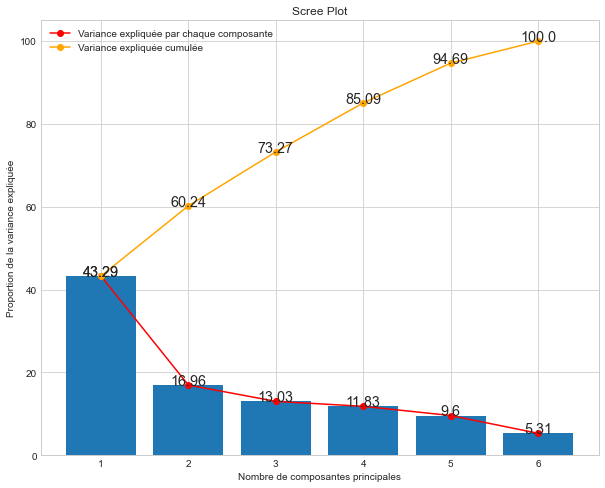

In [20]:
# Calculer la variance expliquée cumulée

explained_variance = pca.explained_variance_ratio_*100

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante',c="r")
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée',c='orange')
for i in range(0,len(explained_variance)):
    plt.text(i+1, cumulative_explained_variance[i], str(round(cumulative_explained_variance[i],2)), ha='center',fontsize='x-large')
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
# Ajout des étiquettes
for i in range(0,len(explained_variance)):
    plt.text(i+1, explained_variance[i], str(round(explained_variance[i],2)), ha='center',fontsize='x-large')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()
fig.savefig('./graphiques/ACP/scree_plot_acp.png',dpi=fig.dpi*10)
plt.close(fig)

### Cercle de correlation ACP

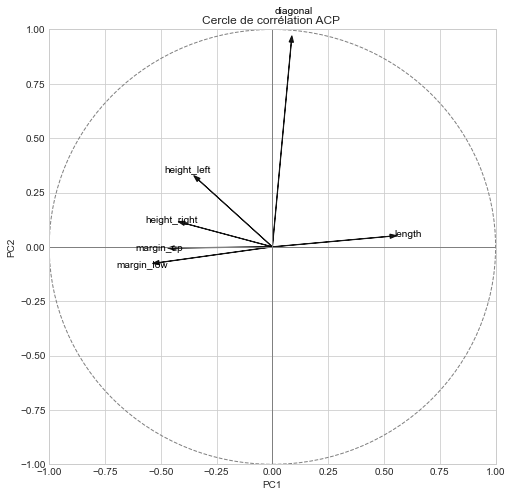

In [21]:

# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
fig = plt.figure(figsize=(8,8))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, X.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()
fig.savefig('./graphiques/ACP/cercle_de_correlation.png',dpi=fig.dpi*10)
plt.close(fig)

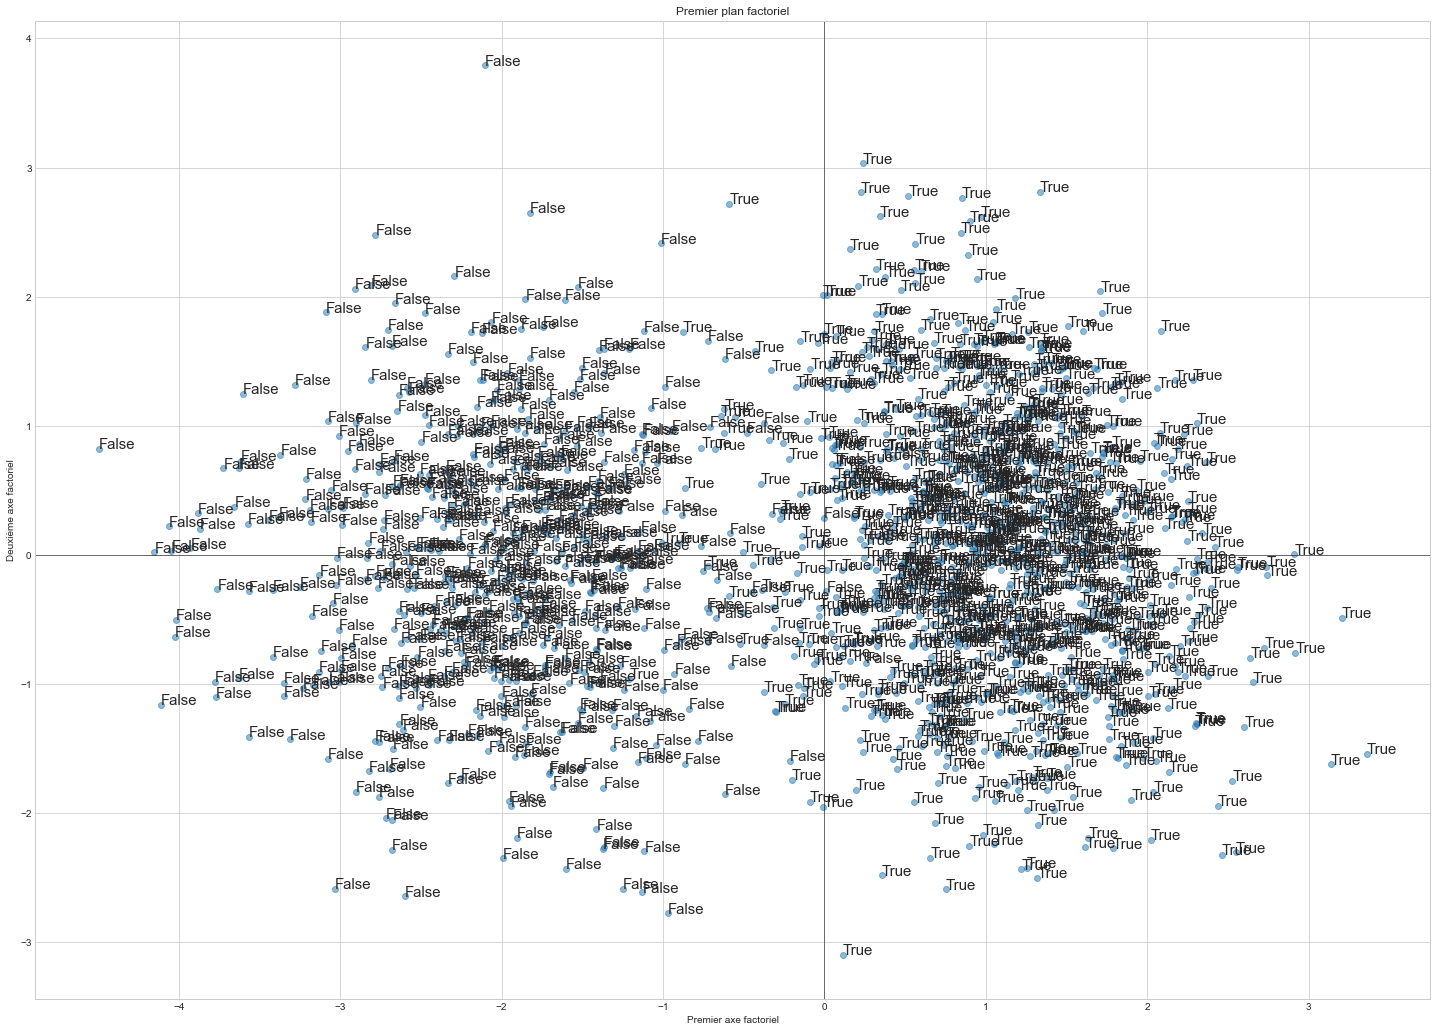

In [22]:
# Premier plan factoriel
fig, ax = plt.subplots(figsize=(25, 18))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)


# Ajouter des étiquettes pour chaque point (billet)
for i, billet in enumerate(billets['is_genuine']):
    ax.annotate(billet, (X_pca[i, 0], X_pca[i, 1]), alpha=1,fontsize=15)

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Premier plan factoriel')

# Afficher le graphique
plt.show()
fig.savefig('./graphiques/ACP/projection_des_individus.png',dpi=fig.dpi*10)
plt.close(fig)

### K-Means

In [23]:
# Choix du nombre optimal de clusters (méthode du coude et du score de silhouette)
inertias = []
silhouettes = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_normalized)
    inertias.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(X_normalized, kmeanModel.labels_))

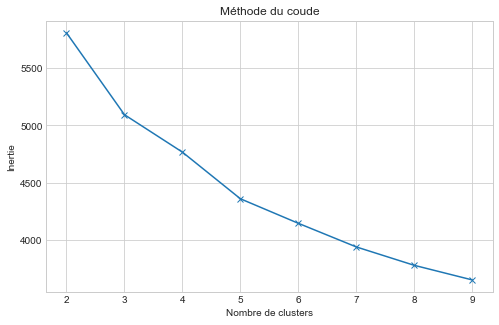

In [24]:
# Tracer la courbe de l'inertie en fonction du nombre de clusters
fig = plt.figure(figsize=(8,5))
plt.plot(range(2, 10), inertias,'x-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()
fig.savefig('./graphiques/ACP/methode_coude.png',dpi=fig.dpi*10)

 La methode du coude et la methode du score de silhouette nous préconisent 3 clusters comme choix optimal .

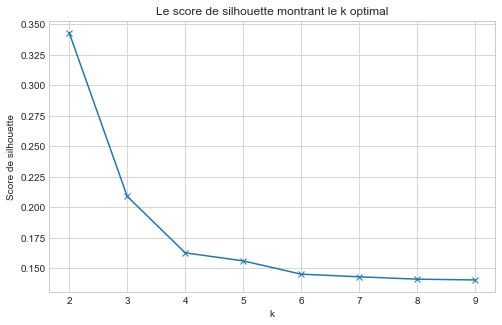

In [25]:
# Graphique du score de silhouette
fig = plt.figure(figsize=(8,5))
# Background color
plt.plot(K, silhouettes, 'x-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()
fig.savefig('score_silhouette_kmeans_1.png',dpi=fig.dpi*10)

In [26]:
# Appliquer KMeans avec le nombre de clusters optimal trouvé 
#(supposons que c'est 2 , car nous voulons comparer avec une classification binaire)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_normalized)




In [27]:
clusters

array([1, 0, 2, ..., 1, 1, 1])

In [28]:
# Ajouter les labels de cluster au DataFrame
billets['cluster_label'] = kmeans.labels_
billets['cluster_label'] = billets['cluster_label'].astype('category')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_encode,cluster_label
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1,0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1,2
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1,0
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1,2
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,0,1
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,0,1
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,0,1
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,0,1


In [29]:
# Interprétation des groupes
# Afficher les statistiques des clusters
billets_numeric = billets.drop(columns=['is_genuine','is_genuine_encode'])
cluster_stats = billets.groupby('cluster_label')[billets_numeric.columns].mean()
cluster_stats

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster_label,,,,,,
0,171.877436,103.734932,103.741448,4.120397,3.030881,113.188415
1,171.896496,104.196148,104.153811,5.232747,3.353996,111.614037
2,172.101397,104.167725,103.875289,4.123842,3.077206,113.195250


In [30]:
#centroids
Kmeanscentroids = kmeans.cluster_centers_

# standardisation  : 
Kmeanscentroids_scaled = scaler.fit_transform(Kmeanscentroids)

# et on utilise l'ACP déjà entrainée : 
Kmeanscentroids_proj = pca.transform(Kmeanscentroids_scaled)

# Création d'un dataframe pour plus de clarté:
Kmeanscentroids_proj = pd.DataFrame(Kmeanscentroids_proj, 
                              columns = ["F1", "F2", "F3", "F4","F5","F6"], 
                              index=["cluster_0", "cluster_1","cluster_2"])
Kmeanscentroids_proj

,F1,F2,F3,F4,F5,F6
cluster_0,1.92937,-1.206962,-0.43099,-0.194921,-0.304890,-0.083911
cluster_1,-2.91388,-0.375533,-0.10089,0.189082,0.228592,0.067492
cluster_2,0.98451,1.582494,0.53188,0.005839,0.076298,0.016419


In [31]:
Kmeanscentroids_proj.iloc[:, 0]

cluster_0    1.92937
cluster_1   -2.91388
cluster_2    0.98451
Name: F1, dtype: float64

In [32]:
Kmeanscentroids_proj.iloc[:, 1]

cluster_0   -1.206962
cluster_1   -0.375533
cluster_2    1.582494
Name: F2, dtype: float64

### Projection sur le 1er plan factoriel

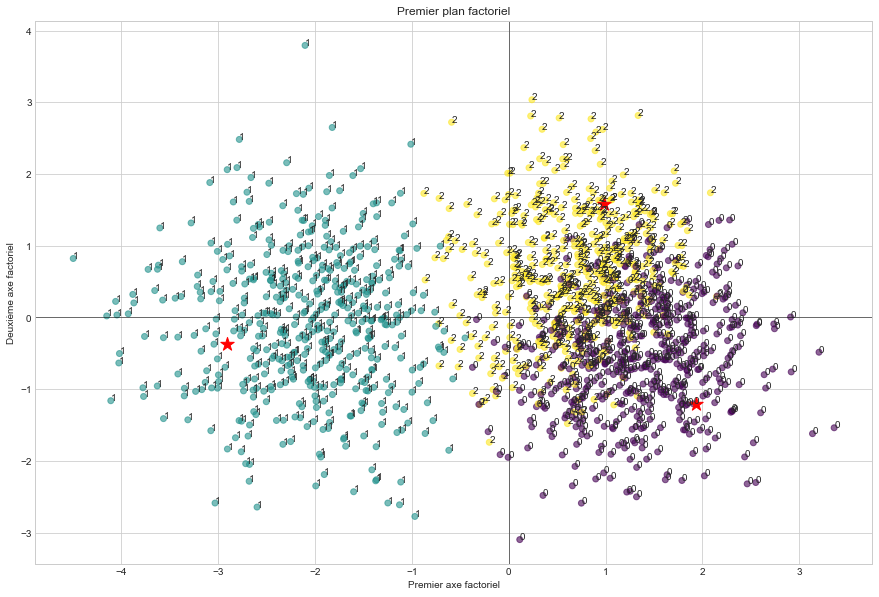

In [33]:
# Premier plan factoriel
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6,c=kmeans.labels_,cmap='viridis')

# On affiche nos centroides, avec une couleur rouge (c="r") et une forme d'étoile (marker="*") : 
ax.scatter(Kmeanscentroids_proj.iloc[:, 0],Kmeanscentroids_proj.iloc[:, 1],   marker="*",s=200, c="r" ,alpha=1) #

#Ajouter des étiquettes pour chaque point (billet)
for i, billet in enumerate(billets['cluster_label']):
    ax.annotate(billet, (X_pca[i, 0], X_pca[i, 1]), alpha=1,fontsize=10 )

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Premier plan factoriel')

# Afficher le graphique
plt.show()
fig.savefig('./graphiques/ACP/Kmeansprojection_cluster_label.png',dpi=fig.dpi*10)
plt.close(fig)


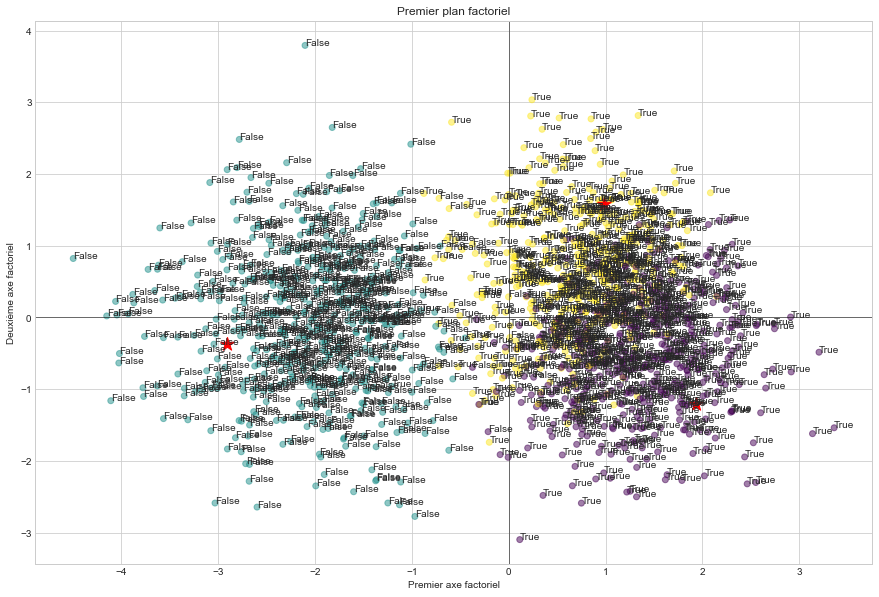

In [34]:
# Premier plan factoriel
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5,c=kmeans.labels_,cmap='viridis')

# On affiche nos centroides, avec une couleur rouge (c="r") et une forme d'étoile (marker="*") : 
ax.scatter(Kmeanscentroids_proj.iloc[:, 0], Kmeanscentroids_proj.iloc[:, 1],  marker="*", c="r" ,s=200,alpha=1)

#Ajouter des étiquettes pour chaque point (type de publication)
for i, billet in enumerate(billets['is_genuine']):
    ax.annotate(billet, (X_pca[i, 0], X_pca[i, 1]), alpha=1,fontsize=10 )

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Premier plan factoriel')

# Afficher le graphique
plt.show()
fig.savefig('./graphiques/ACP/Kmeansprojection_is_genuine.png',dpi=fig.dpi*10)
plt.close(fig)

<div class="alert alert-block alert-info">
 <br>
Nous pouvons nous apercevoir par les 2 graphiques ci dessus que les billets "faux" sont annotés "1" et les billets "vrais" sont notés "0" et "2 par le resultat du Kmeans . L'encodage de la colonne "is_genuine" fait precedemment donne des sortie en "" er         "1"
Nous corrigeons donc cela avant de poursuivre . </br>

In [35]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_encode,cluster_label
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1,0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1,2
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1,0
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1,2
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,0,1
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,0,1
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,0,1
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,0,1


In [36]:
billets['cluster_label'] = [0 if i==1 else 1 for i in billets['cluster_label']]
billets['cluster_label']

0       0
1       1
2       1
3       1
4       1
       ..
1495    0
1496    0
1497    0
1498    0
1499    0
Name: cluster_label, Length: 1500, dtype: int64

In [37]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_encode,cluster_label
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,0
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1,1
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,0,0
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,0,0
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,0,0
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,0,0


In [38]:
billets.loc[X_train.index,"cluster_label"]

382     1
538     1
1493    0
1112    0
324     1
       ..
1130    0
1294    0
860     1
1459    0
1126    0
Name: cluster_label, Length: 1200, dtype: int64

In [39]:
#pour chaque billet , faire des prédictions en attibuant les clusters
y_train_clust_pred = billets.loc[X_train.index,"cluster_label"].values
y_test_clust_pred = billets.loc[X_test.index,"cluster_label"].values

In [40]:
#Évaluer le modèle
# Précision
train_accuracy = accuracy_score(y_train, y_train_clust_pred)
test_accuracy = accuracy_score(y_test, y_test_clust_pred)

print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')




Train Accuracy: 0.99
Test Accuracy: 0.99


In [41]:
confusion_matrix_test = confusion_matrix(y_test,y_test_clust_pred)
confusion_matrix_test = pd.DataFrame(confusion_matrix_test)
confusion_matrix_test.columns = [f"pred_{i}" for i in confusion_matrix_test.columns]
confusion_matrix_test.index = [f"test_{i}" for i in confusion_matrix_test.index]
confusion_matrix_test

,pred_0,pred_1
test_0,107,3
test_1,0,190


In [42]:
# Rapport de classification
class_report = classification_report(y_test, y_test_clust_pred)
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       110
           1       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



<div style="background-color: RGB(58,69,203);" >
<h2 style="margin: auto;color:RGB(255,255,255) ;padding: 20px;margin-left: 4.5em; text-indent: -4.5em">2 - PRODUCTION
</h2>
</div>

<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="41">2 - 1. Prédiction </a></h3>
</div>

In [43]:
billets_production = pd.read_csv("./data/source/billets_production.csv",sep=',')
X_prod =  billets_production[[ 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]

#Faire des prédictions avec le model initial
y_prod_pred = result.predict(X_prod)
billets_production['Probabilite_faux'] = (1 - y_prod_pred)*100
billets_production['is_genuine_true_false'] = ["True" if i<50 else "False" for i in billets_production['Probabilite_faux']]
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Probabilite_faux,is_genuine_true_false
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,99.987151,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,99.998859,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,99.998032,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1.723433,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.000999,True


[RETOUR AU SOMMAIRE](#00)